<a href="https://colab.research.google.com/github/bilibili-deepuser/ST455_HW4/blob/main/ST445_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gymnasium as gym

In [ ]:
# ============================================================
# Plot function (provided)
# ============================================================
def plot_policy(policy, ace=True):
    cmap = plt.cm.get_cmap("Paired")
    colors = list([cmap(0.2), cmap(0.8)])
    label = ["Stick", "Hit"]

    plt.figure(figsize=(15, 6))
    player_range = np.arange(11, 22)
    dealer_range = np.arange(0, 11)

    plt.pcolor(dealer_range, player_range, policy, label=label,
               cmap=mpl.colors.ListedColormap(colors))
    plt.axis([dealer_range.min(), dealer_range.max(),
              player_range.min(), player_range.max()])
    col_bar = plt.colorbar()
    col_bar.set_ticks([0.25, 0.75])
    col_bar.set_ticklabels(label)
    plt.grid()
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Score")
    if ace:
        plt.title(r"Optimal Policy With a Usable Ace ($\pi_*$)")
    else:
        plt.title(r"Optimal Policy Without a Usable Ace ($\pi_*$)")
    plt.show()

In [ ]:
# ============================================================
# MC Control with Exploring Starts
# ============================================================
env = gym.make("Blackjack-v1", sab=True)

n_episodes = 500_000

# State dimensions: player sum 12-21 (10), dealer showing 1-10 (10), usable ace (2)
# Action dimensions: stick (0), hit (1)
Q = np.zeros((10, 10, 2, 2))        # Q(player, dealer, ace, action)
N = np.zeros((10, 10, 2, 2))        # visit counts
Returns = np.zeros((10, 10, 2, 2))  # cumulative returns

# Initial policy: stick (0) if player sum >= 18, else hit (1)
# Shape (10, 10, 2) — indexed by (player_sum - 12, dealer_show - 1, ace)
policy = np.zeros((10, 10, 2), dtype=int)
for p in range(10):
    for d in range(10):
        for a in range(2):
            policy[p, d, a] = 0 if (p + 12) >= 18 else 1

for ep in range(n_episodes):
    # --- Exploring starts: random initial state & action ---
    # Reset env and get initial observation
    obs, _ = env.reset()
    player_sum, dealer_show, usable_ace = obs
    usable_ace = int(usable_ace)

    # Random first action (exploring starts)
    action = env.action_space.sample()

    # --- Generate episode ---
    episode = []  # list of ((p_idx, d_idx, ace_idx), action, reward)
    done = False

    while True:
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store transition (only if player_sum >= 12)
        if player_sum >= 12:
            p_idx = player_sum - 12
            d_idx = dealer_show - 1
            episode.append(((p_idx, d_idx, usable_ace), action))

        if done:
            break

        # Update state
        player_sum, dealer_show, usable_ace = next_obs
        usable_ace = int(usable_ace)

        # Follow current policy for subsequent actions
        if player_sum >= 12:
            action = policy[player_sum - 12, dealer_show - 1, usable_ace]
        else:
            action = 1  # must hit if sum < 12

    # --- First-visit MC update ---
    G = reward  # terminal reward (no discounting needed, gamma=1)
    visited = set()

    for (state, act) in episode:
        sa = (state[0], state[1], state[2], act)
        if sa in visited:
            continue
        visited.add(sa)

        N[sa] += 1
        Returns[sa] += G
        Q[sa] = Returns[sa] / N[sa]

    # --- Policy improvement (greedy) ---
    for (state, _) in episode:
        p_idx, d_idx, ace_idx = state
        policy[p_idx, d_idx, ace_idx] = np.argmax(Q[p_idx, d_idx, ace_idx, :])

env.close()

/tmp/ipython-input-1895565646.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Paired")


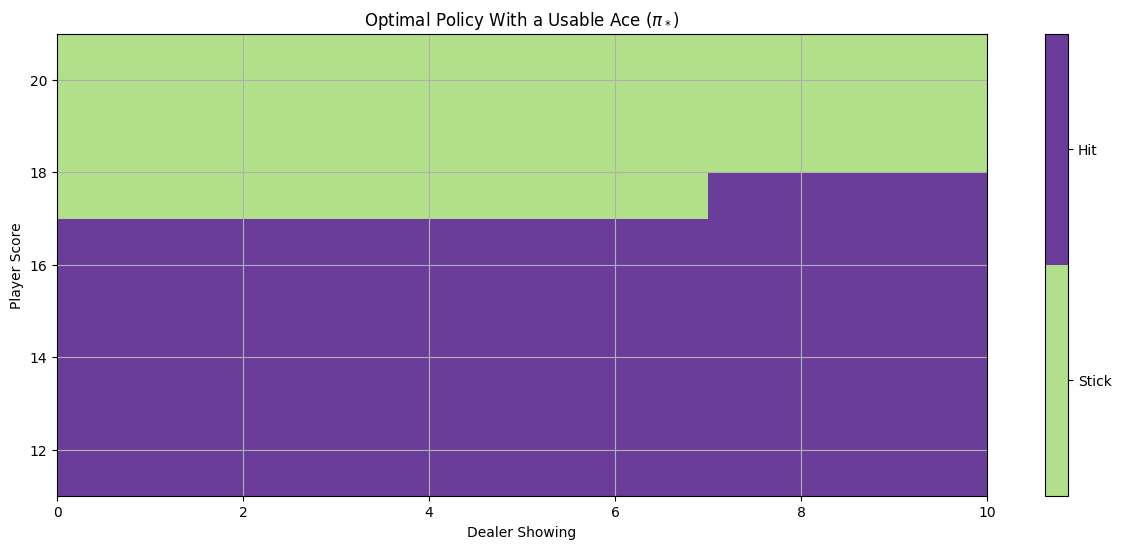

/tmp/ipython-input-1895565646.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Paired")


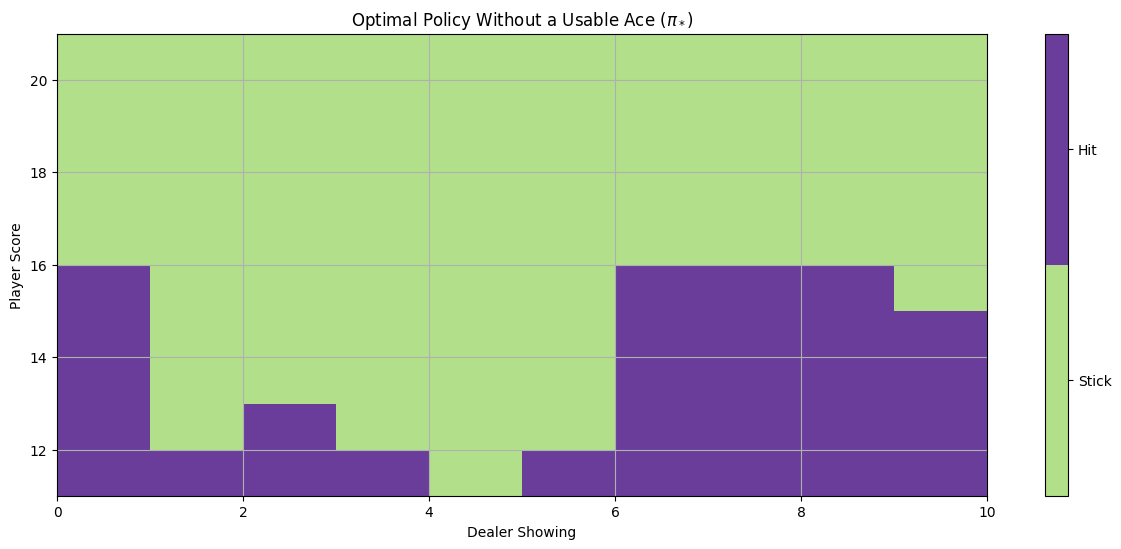

In [ ]:
# ============================================================
# Extract optimal policies as 10x10 binary matrices
# ============================================================
# policy_ace[i, j]: optimal action for player_sum = i+12, dealer_show = j+1, with ace
policy_ace = policy[:, :, 1]      # shape (10, 10)
policy_no_ace = policy[:, :, 0]   # shape (10, 10)

# ============================================================
# Plot
# ============================================================
plot_policy(policy_ace, ace=True)
plot_policy(policy_no_ace, ace=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ============================================================
# Cliff Walking Environment (same as Seminar 4)
# ============================================================
class CliffWalking:
    def __init__(self):
        self.rows = 4
        self.cols = 12
        self.start = (3, 0)
        self.goal = (3, 11)
        # Cliff positions: bottom row, columns 1-10
        self.cliff = [(3, c) for c in range(1, 11)]
        self.state = self.start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        # Actions: 0=up, 1=left, 2=right, 3=down
        r, c = self.state
        if action == 0:
            r = max(r - 1, 0)
        elif action == 1:
            c = max(c - 1, 0)
        elif action == 2:
            c = min(c + 1, self.cols - 1)
        elif action == 3:
            r = min(r + 1, self.rows - 1)

        self.state = (r, c)

        if self.state in self.cliff:
            self.state = self.start
            return self.state, -100, False
        elif self.state == self.goal:
            return self.state, -1, True
        else:
            return self.state, -1, False

In [ ]:
# ============================================================
# Epsilon-greedy policy
# ============================================================
def epsilon_greedy_policy(q_values, state, n_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)
    else:
        # Break ties randomly
        max_val = np.max(q_values[state])
        best_actions = [a for a in range(n_actions) if q_values[state][a] == max_val]
        return np.random.choice(best_actions)

In [ ]:
# ============================================================
# SARSA update
# ============================================================
def sarsa_update(qsa, next_qsa, r, alpha=0.1, gamma=1.0):
    return qsa + alpha * (r + gamma * next_qsa - qsa)

In [ ]:
# ============================================================
# Modified SARSA with epsilon decay
# ============================================================
n_actions = 4
episodes = 500
alpha = 0.1
gamma = 1.0

# --- KEY MODIFICATION ---
# Instead of constant epsilon (e.g. 0.1), we decay epsilon over episodes.
# epsilon_start = 1.0 ensures thorough exploration early on.
# epsilon_end = 0.0 ensures the policy converges to greedy (satisfying
# the convergence theorem, slide 51).
# epsilon_decay controls how fast we transition from exploration to exploitation.
epsilon_start = 1.0
epsilon_end = 0.0
epsilon_decay = 0.01  # exponential decay rate

env = CliffWalking()
q_values = np.zeros((env.rows, env.cols, n_actions))
reward_per_episode = []

for ep in range(episodes):
    # Decaying epsilon: epsilon = epsilon_end + (epsilon_start - epsilon_end) * exp(-decay * ep)
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-epsilon_decay * ep)

    state = env.reset()
    action = epsilon_greedy_policy(q_values, state, n_actions, epsilon)
    total_reward = 0

    done = False
    while not done:
        next_state, reward, done = env.step(action)
        next_action = epsilon_greedy_policy(q_values, next_state, n_actions, epsilon)

        # SARSA update: on-policy, uses Q(s', a') where a' is the action actually taken
        q_values[state][action] = sarsa_update(
            q_values[state][action],
            q_values[next_state][next_action],
            reward, alpha, gamma
        )

        state = next_state
        action = next_action
        total_reward += reward

    reward_per_episode.append(total_reward)

In [ ]:
# ============================================================
# Extract and display the optimal policy
# ============================================================
action_labels = ['U', 'L', 'R', 'D']
policy = np.full((env.rows, env.cols), ' ', dtype='<U2')

for r in range(env.rows):
    for c in range(env.cols):
        if (r, c) == env.goal:
            policy[r, c] = 'G'
        elif (r, c) in env.cliff:
            policy[r, c] = 'X'
        else:
            best_action = np.argmax(q_values[r, c])
            policy[r, c] = action_labels[best_action]

print("Estimated Optimal Policy:")
print("-" * 50)
for r in range(env.rows):
    row_str = "  ".join(f"{policy[r, c]:>2}" for c in range(env.cols))
    print(f"[{row_str}]")
print("-" * 50)
print("U=Up, D=Down, L=Left, R=Right, G=Goal, X=Cliff")

Estimated Optimal Policy:
--------------------------------------------------
[ R   R   R   R   R   R   R   R   R   R   R   D]
[ U   U   U   R   U   U   U   U   U   R   R   D]
[ U   U   U   U   U   U   R   U   U   R   R   D]
[ U   X   X   X   X   X   X   X   X   X   X   G]
--------------------------------------------------
U=Up, D=Down, L=Left, R=Right, G=Goal, X=Cliff


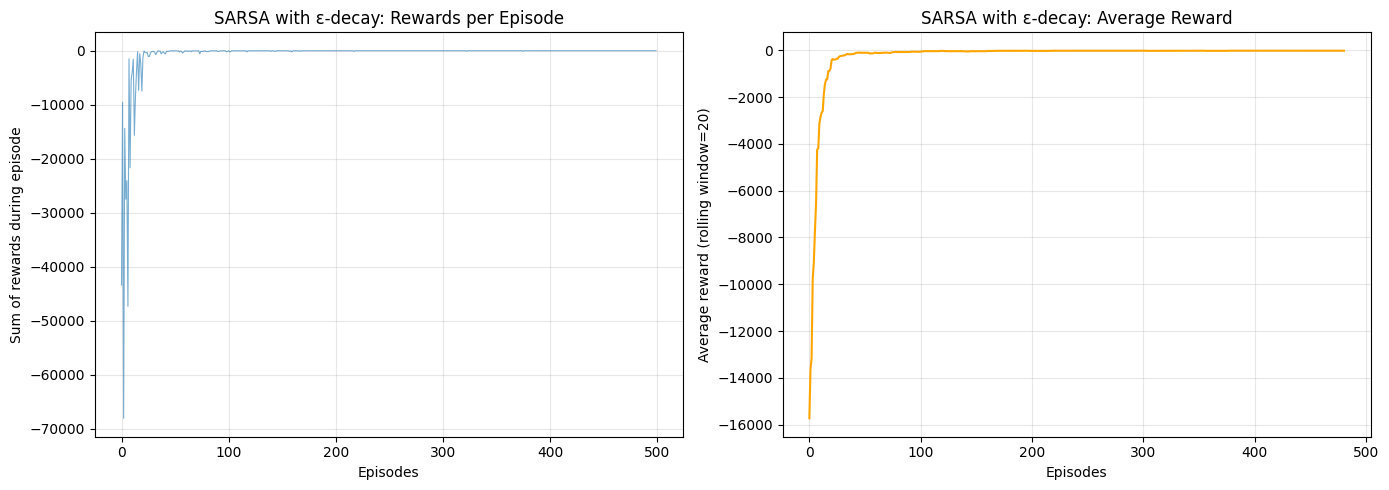


Epsilon schedule:
  Episode 0:   ε = 1.0000
  Episode 100: ε = 0.3679
  Episode 300: ε = 0.0498
  Episode 499: ε = 0.0068


In [ ]:
# ============================================================
# Plot average reward during episodes
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sum of rewards per episode
axes[0].plot(reward_per_episode, alpha=0.6, linewidth=0.8)
axes[0].set_xlabel('Episodes')
axes[0].set_ylabel('Sum of rewards during episode')
axes[0].set_title('SARSA with ε-decay: Rewards per Episode')
axes[0].grid(True, alpha=0.3)

# Plot 2: Running average reward (window of 20 episodes)
window = 20
avg_rewards = np.convolve(reward_per_episode, np.ones(window)/window, mode='valid')
axes[1].plot(avg_rewards, color='orange', linewidth=1.5)
axes[1].set_xlabel('Episodes')
axes[1].set_ylabel('Average reward (rolling window=20)')
axes[1].set_title('SARSA with ε-decay: Average Reward')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sarsa_optimal_cliff_walking.png', dpi=150, bbox_inches='tight')
plt.show()

# Print epsilon schedule info
print(f"\nEpsilon schedule:")
print(f"  Episode 0:   ε = {epsilon_start:.4f}")
print(f"  Episode 100: ε = {epsilon_end + (epsilon_start - epsilon_end) * np.exp(-epsilon_decay * 100):.4f}")
print(f"  Episode 300: ε = {epsilon_end + (epsilon_start - epsilon_end) * np.exp(-epsilon_decay * 300):.4f}")
print(f"  Episode 499: ε = {epsilon_end + (epsilon_start - epsilon_end) * np.exp(-epsilon_decay * 499):.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [ ]:
class CliffWalking:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    def is_cliff(self):
        cliff = np.zeros((world_height, world_width), dtype=bool)
        cliff[3, 1: -1] = True
        return cliff[tuple(self.state)]

    # return next_state, reward, done
    def step(self, action):
        i, j = self.state

        if action == up:
            self.state = [max(i - 1, 0), j]
        elif action == left:
            self.state = [i, max(j - 1, 0)]
        elif action == right:
            self.state = [i, min(j + 1, world_width - 1)]
        elif action == down:
            self.state = [min(i + 1, world_height - 1), j]
        else:
            assert False, "Actions should be in the range of (0, 4)"

        if self.is_cliff():
            self.state = self.initial_state
            self.reward = -100.0
            self.is_terminal = False
        elif self.state == self.goal_state:
            self.state = self.state
            self.reward = 0.0
            self.is_terminal = True
        else:
            self.reward = -1.0
            self.is_terminal = False
        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

In [ ]:
def is_cliff(self):
    cliff = np.zeros((world_height, world_width), dtype=np.bool)
    cliff[3, 1: -1] = True
    return cliff[tuple(self.state)]

In [ ]:
def eps_greedy_policy(qsa, epsilon=0.1):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(qsa) if value_ == np.max(qsa)])

def sarsa(qsa, next_qsa, r, alpha=0.1, gamma=1.0):
    return qsa + alpha * (r + gamma * next_qsa - qsa)

def q_learning(qsa, next_qs, r, alpha=0.1, gamma=1.0):
    return qsa + alpha * (r + gamma * np.max(next_qs) - qsa)

In [ ]:
start_position = [3, 0]
goal = [3, 11]
world_width = 12
world_height = 4
# actions
up = 0
left = 1
right = 2
down = 3
actions = [up, left, right, down]
epsilon_decay = 0.01


In [ ]:
import numpy as np
env_sarsa = CliffWalking(start_position, goal)
env_sarsa_edited = CliffWalking(start_position, goal)
env_q_learning = CliffWalking(start_position, goal)

runs = 10
episodes = 500
rewards_sarsa = np.zeros(episodes)
rewards_sarsa_edited = np.zeros_like(rewards_sarsa)
rewards_qlearning = np.zeros_like(rewards_sarsa)

for r in range(runs):
    q_sarsa = np.zeros((world_height, world_width, len(actions)))
    q_sarsa_edited = np.zeros_like(q_sarsa)
    q_qlearning = np.zeros_like(q_sarsa)

    for i in range(episodes):
        state_sarsa = env_sarsa.reset()
        state_sarsa_edited = env_sarsa_edited.reset()
        state_q = env_q_learning.reset()
        epsilon_i = 1 * np.exp(-epsilon_decay * i)

        done_sarsa = False
        done_sarsa_edited = False
        done_q = False

        # choose an action based on current state
        row, col = state_sarsa
        row_edited, col_edited = state_sarsa_edited
        a_sarsa = eps_greedy_policy(q_sarsa_edited[row, col, :])
        a_sarsa_edited = eps_greedy_policy(q_sarsa_edited[row, col, :], epsilon=epsilon_i)
        g_sarsa = 0.0
        g_sarsa_edited = 0.0
        g_q = 0.0

        #Sarsa
        while not done_sarsa:
            next_state_sarsa, r_sarsa, done_sarsa = env_sarsa.step(a_sarsa)

            # choose an action for the next state
            row, col = state_sarsa
            n_row, n_col = next_state_sarsa
            next_a_sarsa = eps_greedy_policy(q_sarsa[n_row, n_col, :])
            g_sarsa += r_sarsa
            # sarsa updates
            q_sarsa[row, col, a_sarsa] = sarsa(q_sarsa[row, col, a_sarsa], q_sarsa[n_row, n_col, next_a_sarsa], r_sarsa)

            state_sarsa = next_state_sarsa
            a_sarsa = next_a_sarsa


        #Sarsa_edited
        while not done_sarsa_edited:
            next_state_sarsa_edited, r_sarsa_edited, done_sarsa_edited = env_sarsa_edited.step(a_sarsa_edited)

            # choose an action for the next state
            row_edited, col_edited = state_sarsa_edited
            n_row, n_col = next_state_sarsa_edited
            next_a_sarsa_edited = eps_greedy_policy(q_sarsa_edited[n_row, n_col, :], epsilon=epsilon_i)
            g_sarsa_edited += r_sarsa_edited
            # sarsa updates
            q_sarsa_edited[row_edited, col_edited, a_sarsa_edited] = sarsa(q_sarsa_edited[row_edited, col_edited, a_sarsa_edited], q_sarsa_edited[n_row, n_col, next_a_sarsa_edited], r_sarsa_edited)

            state_sarsa_edited = next_state_sarsa_edited
            a_sarsa_edited = next_a_sarsa_edited


        #Q-Learning
        while not done_q:
            row_q, col_q = state_q
            a_q = eps_greedy_policy(q_qlearning[row_q, col_q, :])
            next_state_q, r_q, done_q = env_q_learning.step(a_q)
            g_q += r_q

            # Q-learning updates, note the second argument
            n_row_q, n_col_q = next_state_q
            q_qlearning[row_q, col_q, a_q] = q_learning(q_qlearning[row_q, col_q, a_q],
                                                        q_qlearning[n_row_q, n_col_q, :], r_q)
            state_q= next_state_q

        rewards_sarsa[i] += g_sarsa
        rewards_sarsa_edited[i] += g_sarsa_edited
        rewards_qlearning[i] += g_q

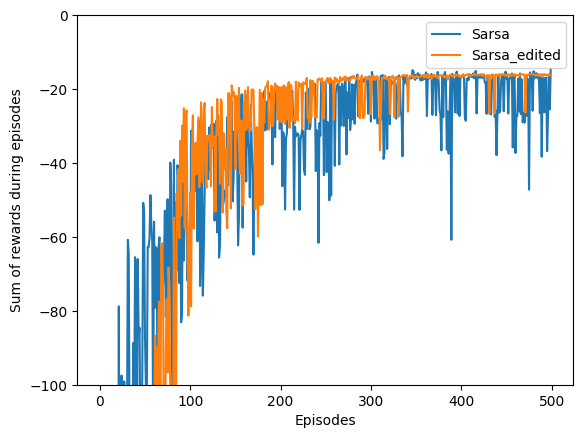

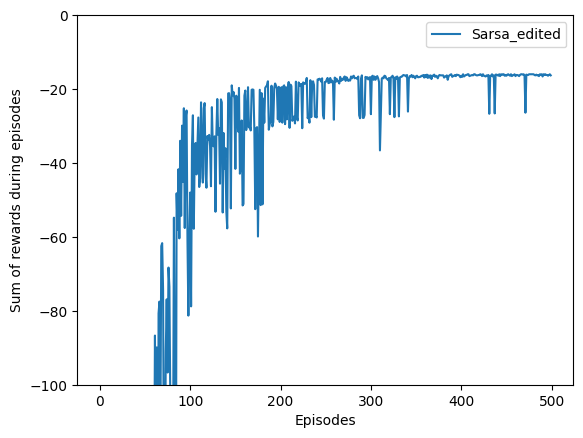

In [ ]:
import matplotlib.pyplot as plt
def plot_rewards(plots):
    plt.figure()
    for plot in plots:
        method, method_title = plot
        plt.plot(method, label=method_title)
    # plt.plot(r_qlearning, label='Q-learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episodes')
    plt.ylim([-100, 0])
    plt.legend()
    plt.show()


rewards_sarsa /= runs
rewards_sarsa_edited /= runs
rewards_qlearning /= runs

plot_rewards([[rewards_sarsa, 'Sarsa'], [rewards_sarsa_edited, 'Sarsa_edited']])


In [ ]:
def print_optimal_policy(policy, method):
    policy_display = np.empty_like(policy, dtype=str)
    for i in range(0, world_height):
        for j in range(0, world_width):
            if [i, j] == [3, 11]:
                policy_display[i, j] = 'G'
                continue
            if i == 3 and j in np.arange(1,11):
                policy_display[i, j] = 'C'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'
    print(method + ' Optimal policy is:')
    for row in policy_display:
        print(row)

optimal_policy = np.argmax(q_sarsa, axis=2)
print_optimal_policy(optimal_policy, 'SARSA')

optimal_policy = np.argmax(q_sarsa_edited, axis=2)
print_optimal_policy(optimal_policy, 'SARSA_edited')

optimal_policy = np.argmax(q_qlearning, axis=2)
print_optimal_policy(optimal_policy, 'Q-Learning')

SARSA Optimal policy is:
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D' 'R' 'D']
['U' 'R' 'U' 'R' 'L' 'U' 'U' 'R' 'R' 'R' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']
SARSA_edited Optimal policy is:
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['R' 'U' 'R' 'R' 'R' 'U' 'R' 'R' 'U' 'R' 'R' 'D']
['U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'U' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']
Q-Learning Optimal policy is:
['D' 'D' 'D' 'R' 'R' 'D' 'R' 'L' 'R' 'U' 'D' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'D' 'R' 'R' 'R' 'D' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']
